# Reconocimiento de patrones: Identificación de grupos o Clustering
### Ramón Soto C. [(rsotoc@moviquest.com)](mailto:rsotoc@moviquest.com/)
![ ](images/blank.png)
![agents](images/binary_data_under_a_magnifying.jpg)
[ver en nbviewer](http://nbviewer.ipython.org/github/rsotoc/pattern-recognition/blob/master/Clustering%20V.ipynb)

## Técnicas de clustering: *DBSCAN*

Las técnicas de clustering jerárquico (como los dendrogramas y los métodos de particionamiento, como el *k-medias*, asumen una forma convexa de los conjuntos: estos métodos son buena opción para datos con clases compactas y bien separadas, pero son afectados severamente cuando las clases tienen formas dispersas, alargadas sobre un eje o concavas, así como ante valores atípicos o ruido. 

Considérese por ejemplo el siguiente conjunto de datos (tomado del [repositorio Factoextra de Alboukadel Kassambara](https://github.com/kassambara/factoextra)):

In [1]:
# Inicializar el ambiente
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn import metrics

from matplotlib import pyplot as plt
%matplotlib inline

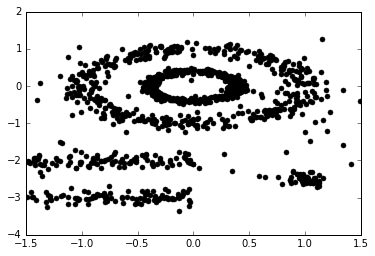

In [2]:
multishapes = pd.read_csv("Data sets/Factoextra/multishapes_raw.csv").values
plt.plot(multishapes[:, 0], multishapes[:, 1], 'o', 
         markeredgecolor='0', markerfacecolor='0', markersize=5)
plt.show()

En estos datos pueden apreciarse claramente 5 o 4 clases, dependiendo de si los dos clusters elípticos se consideran clases separadas o una sola clase. A continuación utilizamos el método k-medias con 5 clases:

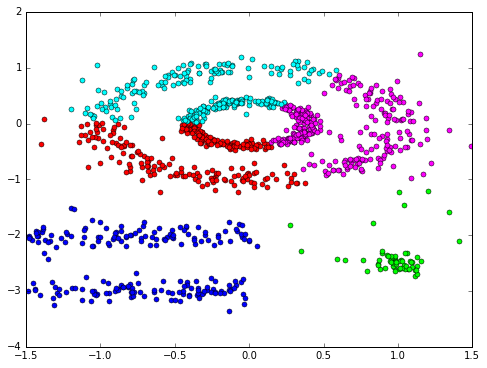

In [3]:
multishapes = pd.read_csv("Data sets/Factoextra/multishapes_raw.csv").values

num_clusters = 5
k_means = cluster.KMeans(n_clusters=num_clusters, init='random')
k_means.fit(multishapes)

fig = plt.figure(figsize=(8, 6))
colors = ['#ff0000', '#00ff00', '#0000ff', '#ff00ff', '#00ffff', '#ffff00', '#f6ff00', 
          '#2f800f', '#a221b5', '#21b5ac', '#b1216c']
for k in range(num_clusters):
    my_members = k_means.labels_ == k
    plt.plot(multishapes[my_members, 0], multishapes[my_members, 1], 'o', 
             markeredgecolor='k', markerfacecolor=colors[k], markersize=5)

Podemos observar resultados inesperados, especialmente en la identificación de la(s) clase(s) elíptica(s).

A continuación aplicamos el método con $k=6$ y el resultados es:

![](images/k-means5a.png)

y con $k=4$

![](images/k-means5b.png)

Se destacan los resultados dudosos en puntos que pueden ser considerados como ruido o com valores atípicos, como en las zonas señaladas.

El algoritmo **DBSCAN** (*Density-Based Spatial Clustering and Application with Noise*) visualiza los clusters como áreas de alta densidad separadas por áreas de baja densidad. Gracias a este enfoque, DBSCAN es capaz de identificar adecuadamente cualquier forma de cluster. Por ejemplo, el siguiente es un resultado obtenido con los datos de Factoestra:

![](images/dbscan_1.png)

Otras caracteríiticas importantes del algoritmo DBSCAN son:

1. DBSCAN no requiere que el usuario especifique el número de clusters a *priori*.

2. DBSCAN es capaz de identificar valores atípicos (puntos en negro en la imagen anterior).

La idea básica detrás del método DBSCAN se deriva de los principios de percepción: en la imagen a continuación, reconocemos la presencia de agrupamientos debido a que en ciertas áreas (los clusters), la densidad es mayor que fuera de ellos. Así mismo, reconocemos puntos de ruido (y valores atípicos), debido a que se encuentran en regiones de baja densidad.

![](images/dbscan_idea.png) Tomado de [Ester et al. 1996](http://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD-96.final.frame.pdf)

### Algoritmo

El objetivo del método es identificar regiones de alta densidad, lo cual puede medirse a partir del número de elementos cercanos a un punto. La idea clave es que para cada punto en un cluster, dado un determinado radio de vecindad $\epsilon$ ('$EPS$'), debe haber un cierto número mínimo de puntos vecinos ('$MinPts$').

![](images/dbscan_principle.png)

El método distingue tres tipos de puntos: 

* **Punto núcleo**: Es cualquier punto $x$ que contenga en su vecindad $\epsilon$ al menos $MinPts$ puntos vecinos. Estos puntos se dice que son *directamente alcanzables* desde $x$.

* **Punto de frontera**: Es cualquier punto $x$ cuya vecindad $\epsilon$ contiene menos de $MinPts$ puntos vecinos pero tal que $x$ es *directamente alcanzable* desde un punto núcleo.

* Si un punto no es *punto núcleo* ni *punto de frontera* entonces se considera ruido o dato atípico; DBSCAN no distingue entre ambos. 

El punto $q$ se dice que es (*densamente*) *alcanzable* desde $p$ si existe una secuencia de puntos $p_1=p, \ldots, p_n=q$ donde cada punto $p_{i+1}$ es directamente alcanzable desde $p_i$; todos los puntos deben ser puntos núcleo, con la posible excepción de $q$. 

En la imagen siguiente, $minPts = 3$. El punto $A$ y los otros puntos rojos son puntos núcleo. Los puntos $B$ y $C$ son puntos frontera y son (*densamente*) *alcanzable* desde $A$. El punto $N$ es un dato atípico/ruido.

![](images/dbscan_2.png)

Un punto $q$ se dice que está *densamente conectado* al punto $p$ si existe un punto $o$ tal que $p$ y $q$ son (densamente) alcanzables desde $o$

#### Algoritmo

El algoritmo DBSCAN puede expresarse, de forma simplificada, como:

1. Para cada punto $x_i$, calcular la distancia entre $x_i$ y los otros puntos y contar los los puntos que se encuentran a una distancia no mayor a $\epsilon$ desde $x_i$. Los puntos con un contador de vecinos mayor o igual a $MinPts$ se marcan como puntos núcleo y como puntos visitados.

2. Para cada punto núcleo $x_i$ que no ha sido asignado a un cluster, crear un nuevo agrupamiento y hacerlo crecer recursivamente, agregando todos los puntos no asignados a un cluster y que se encuentren conectados densamente a $x_i$. 


#### sklearn.cluster.DBSCAN

En esta implementación $\epsilon \in (0,1]$ se define como el valor máximo permitido de la distancia promedio de los $k$ vecinos más próximos a cada punto en un cluster. La idea central es que la distancia promedio de los elementos de un cluster con sus $k$ vecinos más próximos es relativamente pequeña, mientras que las distancias promedio de los $k$ vecinos más próximos a puntos de ruido o con valores atípicos es grande. Se calcula entonces, para cada punto en el conjunto, la distancia promedio a sus $k = MinPts$ vecinos más próximos; a continuación se ordenan las distancias obtenidas ascendentemente (o descendentemente) y se selecciona como valor de $\epsilon$ el valor del codo de la curva (el punto donde la curva cambia drásticamente su pendiente):

![](images/dbscan_eps.png)

Una opción común es hacer el cálculo sobre distancias normalizadas; Esta es la elección en la implementación del algoritmo en la biblioteca **[sklearn.cluster.DBSCAN](http://scikit-learn.org/stable/modules/clustering.html#dbscan)**.

A continuación, la detección de grupos en los datos de *factoextra*.

{0, 1, 2, 3, -1}


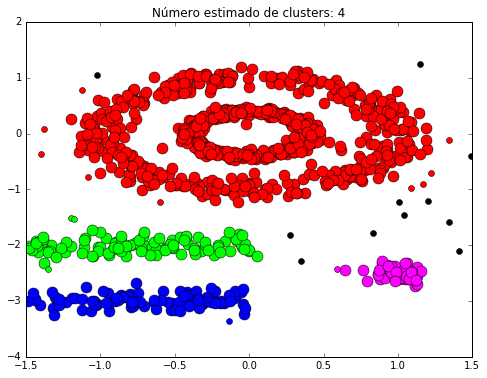

In [4]:
db = cluster.DBSCAN(eps=0.3, min_samples=10)
db.fit(multishapes)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

unique_labels = set(db.labels_)
print(unique_labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(unique_labels) - (1 if -1 in db.labels_ else 0)

fig = plt.figure(figsize=(8, 6))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    my_members = db.labels_ == k

    xy = multishapes[my_members & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=col, markeredgecolor='k', markersize=11)

    xy = multishapes[my_members & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=col, markeredgecolor='k', markersize=6)
    
plt.title('Número estimado de clusters: %d' % n_clusters_)
plt.show()

#### Principales ventajas

* DBSCAN no requiere que se le especifique *a priori* el número de clusters.
* DBSCAN puede identificar clusters de forma arbitraria. 
* DBSCAN hace un buen tratamiento de valores atípicos/ruido.

#### Principales desventajas

* DBSCAN no es completamente determinista: Los puntos de frontera que son alcanzables desde diferentes clusters son asignados a un cluster dependiendo del orden de los datos.
* DBSCAN no es útil en problemas donde las clases tienen diferentes grados de densidad, debido a que en ese caso, no es posible obtener un valor de vecindad adecuada para todos los clusters.

<hr style="border-width: 3px;">

### Tarea 7

* Aplicar el método DBSCAN a un conjunto de datos de su preferencia.

**Fecha de entrega**: Martes 28 de febrero.